In [1]:
import numpy as np
import pandas as pd
import neattext.functions as ntx
from matplotlib import pyplot as plt
import seaborn as sns
import neattext.functions as ntx
import nltk
from nltk.corpus import stopwords
import joblib



from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

%matplotlib inline


## Preparation de l"environnement :

#### Creation et activation d'un environnement virtuel avec conda :

```cmd
conda create --name nlp python=3.10 -y
```

```cmd
conda activate nlp
```

#### Ouvrir VS Code dans le reertoire du travail :

```cmd
(nlp) C:\Users\Asus_M\Desktop\Projects - Realisations\Projet-de-classification-des-motions-textuelles>code .
```

#### Installer les librairies utiles:

```cmd
(nlp) C:\Users\Asus_M\Desktop\Projects - Realisations\Projet-de-classification-des-motions-textuelles>pip install -r requirements.txt
```

## Importation des données :

#### Lien des données Kaggle:

[Télécharger les données ici](https://www.kaggle.com/datasets/subhajournal/tweet-sentiment-and-emotion-analysis)

In [2]:

df = pd.read_csv('../data/all_tweets.csv')

### Analyse Exploartoire des données :

#### Dans cette partie, nous nous concentrerons sur l'extraction des sentiments, les mots-clés pour chaque émotion et le WordCloud

#### Afficher les 5 premieres observations:

In [3]:
df.head()

,Unnamed: 0,sentiment,text,user,label
0,0,positive,RT @SchudioTv: Want to know more about #autism...,beyondbehaviour,anxiety
1,1,negative,We blame ourselves and feel worse. Start with ...,cherie7c,anxiety
2,2,positive,"RT @PsychiatristCNS: 130,000 patient years and...",ThinkNeha,anxiety
3,3,neutral,RT @SkypeTherapist: See a therapist online ove...,FrankCoulson7,anxiety
4,4,positive,"RT @PsychiatristCNS: 130,000 patient years and...",Phcourtet,anxiety


#### Afficher les 5 dernieres observations:

In [4]:
df.tail()

,Unnamed: 0,sentiment,text,user,label
6027,93,negative,"RT @EssBee_Alias: 2/3\nI noticed something,tho...",FromOneLine,stress
6028,94,negative,Was there a collective bad day today? Everyone...,lumieart,stress
6029,95,positive,wen i’m sad I literally got no one to talk to ...,_floracostaa,stress
6030,96,positive,@AustinTweets3 @BirdsPhan228 @Stephfortrump1 @...,Exreenx,stress
6031,97,neutral,RT @DamendraPatel2: #HowToBeHappy\nमनुष्य शरीर...,AneetaY07941551,stress


#### Afficher 5 echantillons d'bservations:

df.sample(5)

#### Dimensions de la base de données :

In [5]:
df.shape

(6032, 5)

La Base de données comporte 6032 observations et 5 variables.

#### Type de données dans la base de données:

In [6]:
df.dtypes

Unnamed: 0     int64
sentiment     object
text          object
user          object
label         object
dtype: object

#### Detections des valeurs manquantes:

In [7]:
df.isnull().sum()

Unnamed: 0    0
sentiment     0
text          0
user          0
label         0
dtype: int64

#### Suppression des colonnes inutiles pour le modele:

In [8]:
df.drop(columns = ['Unnamed: 0','user'],
        axis = 1,
        inplace = True
        )

df.head()

,sentiment,text,label
0,positive,RT @SchudioTv: Want to know more about #autism...,anxiety
1,negative,We blame ourselves and feel worse. Start with ...,anxiety
2,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety
3,neutral,RT @SkypeTherapist: See a therapist online ove...,anxiety
4,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety


#### Nombre de classes dans la cible : label

In [9]:
df['label'].value_counts()

label
happy         2698
depression    1395
anxiety       1364
stress         575
Name: count, dtype: int64

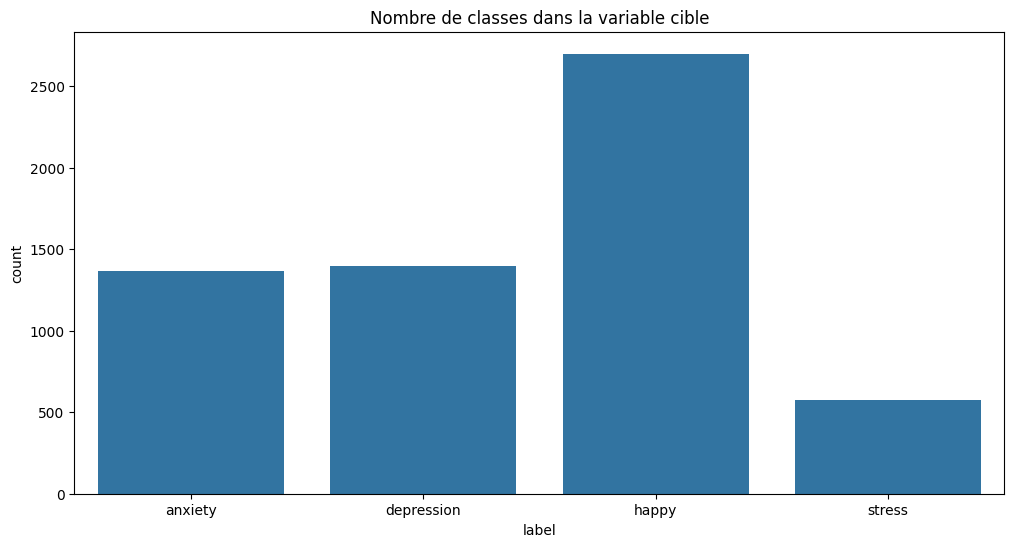

In [10]:
plt.figure(figsize = (12,6))
sns.countplot(data = df,
            x = 'label',
            )
plt.title("Nombre de classes dans la variable cible")

plt.savefig("../visualizations/Nombre de classes dans la variable cible.png")
plt.show()

#### Commentaires:

- La base données est non ballancée :
    -   La classe happy est dominante.
    - La classe strees est peu représentée

#### Extraction des sentiments par emotion:

<Figure size 1200x600 with 0 Axes>

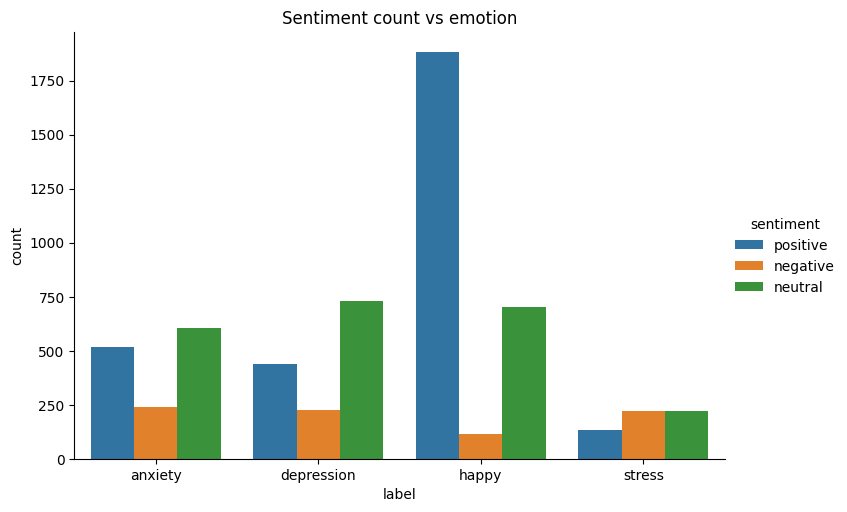

In [11]:
plt.figure(figsize = (12,6))
sns.catplot(data = df,
            x = 'label',
            hue = 'sentiment',
            kind = 'count',
            aspect = 1.5)
plt.title("Sentiment count vs emotion")

plt.savefig("../visualizations/Sentiment count vs emotion.png")
plt.savefig("Sentiment count vs emotion.png")
plt.show()

#### Commentaires:

- La distribution du sentiment par rapport a l'emotion est differente.
- Le graphe explique bien cette distribution.

#### Nettoyage de données :

#### On utilise neattext /clean-text /nltk



In [12]:
dir(ntx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [13]:
df['text']

0       RT @SchudioTv: Want to know more about #autism...
1       We blame ourselves and feel worse. Start with ...
2       RT @PsychiatristCNS: 130,000 patient years and...
3       RT @SkypeTherapist: See a therapist online ove...
4       RT @PsychiatristCNS: 130,000 patient years and...
                              ...                        
6027    RT @EssBee_Alias: 2/3\nI noticed something,tho...
6028    Was there a collective bad day today? Everyone...
6029    wen i’m sad I literally got no one to talk to ...
6030    @AustinTweets3 @BirdsPhan228 @Stephfortrump1 @...
6031    RT @DamendraPatel2: #HowToBeHappy\nमनुष्य शरीर...
Name: text, Length: 6032, dtype: object

#### Suppression de : 
-   Stopwords
-   Punctuations
-   Caracteres speciaux
-   Userhandles
-   URLs
-   Emojis

#### Tokenize word:

In [14]:
def remove_short_words(tweet):
    # Tokenize the text
    tokens = tweet.split()
    # Filter out words of length 2 or less
    filtered_tokens = [token for token in tokens if len(token) > 2]
    # Join the remaining tokens back into a single string
    cleaned_tweet = ' '.join(filtered_tokens)
    return cleaned_tweet

In [15]:
df['clean_text'] = df['text'].apply(remove_short_words)
df['clean_text'] = df['clean_text'].str.lower()
df['clean_text'] = df['clean_text'].apply(ntx.remove_stopwords)
df['clean_text'] = df['clean_text'].apply(ntx.remove_userhandles)
df['clean_text'] = df['clean_text'].apply(ntx.remove_hashtags)
df['clean_text'] = df['clean_text'].apply(ntx.remove_punctuations)
df['clean_text'] = df['clean_text'].apply(ntx.remove_special_characters)
df['clean_text'] = df['clean_text'].apply(ntx.remove_urls)
df['clean_text'] = df['clean_text'].apply(ntx.remove_emojis)

df.head()

,sentiment,text,label,clean_text
0,positive,RT @SchudioTv: Want to know more about #autism...,anxiety,want know watch short clip belownnclick ...
1,negative,We blame ourselves and feel worse. Start with ...,anxiety,blame feel worse start selfcompassion deserve ...
2,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety,130000 patient years diagnostic stability ...
3,neutral,RT @SkypeTherapist: See a therapist online ove...,anxiety,therapist online skype learn overcome amp ...
4,positive,"RT @PsychiatristCNS: 130,000 patient years and...",anxiety,130000 patient years diagnostic stability ...


#### Extraction des mots-clés pour chaque émotion :

In [16]:
emotion_list = df['label'].unique().tolist()
emotion_list

['anxiety', 'depression', 'happy', 'stress']

In [17]:
def extract_keywords(text,n = 50):
    tokens = [token for token in text.split()]
    most_common_word = Counter(tokens).most_common(n)
    return dict(most_common_word)

In [18]:
def plot_most_common_wors(mydict,emotion_name):
    dataframe = pd.DataFrame(mydict.items(),columns = ['token','count'])
    plt.figure(figsize=(12,8))
    sns.barplot(data = dataframe,x = 'token',y = 'count')
    plt.title(f"Representation des mots-clé pour l'emotion  : {emotion_name}")
    plt.xticks(rotation=90)
    plt.savefig(f"../visualizations/Representation des mots-clé de l'emotion {emotion_name}.png")
    plt.show()

In [19]:
def plot_wordcloud(docx,emotion_name):
    mywordcloud = WordCloud(relative_scaling=0.5).generate(docx)
    plt.figure(figsize  = (12,8))
    plt.imshow(mywordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f"../visualizations/WordCloud de l'emotion {emotion_name}.png")
    plt.show()

#### Procedons maintenant a chaque emotion a part:

Emotion : anxiety

In [20]:
anxiety_list = df[df['label'] == 'anxiety']['clean_text'].tolist()
anxiety_docx = ' '.join(anxiety_list)

In [21]:
anxiety_keywords = extract_keywords(anxiety_docx)

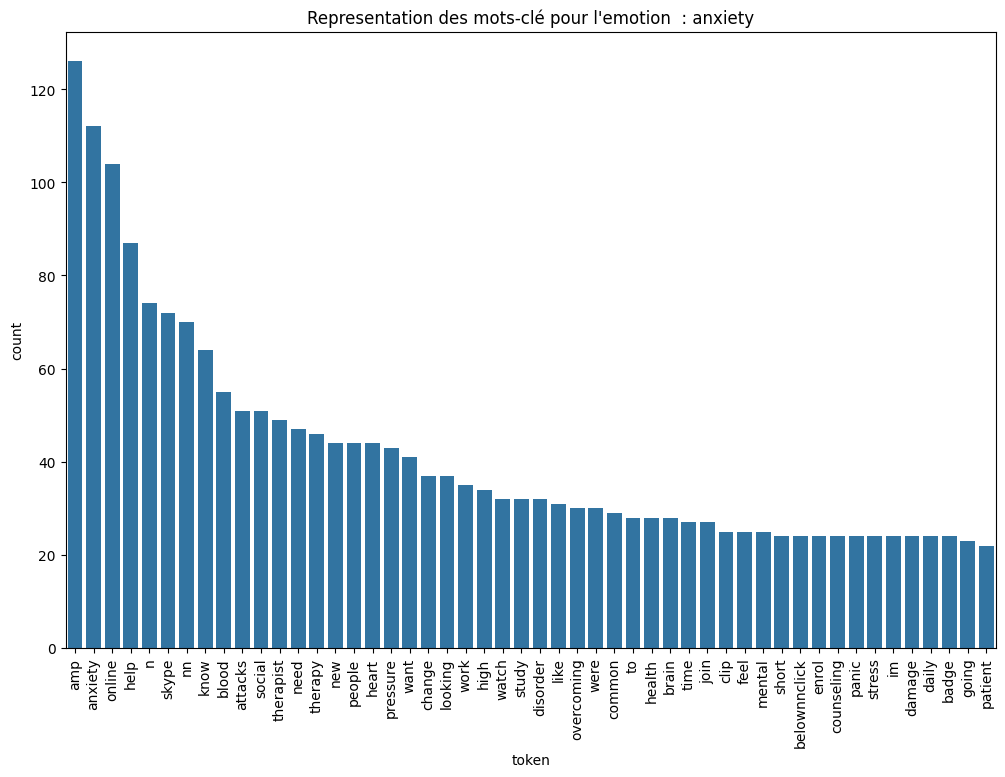

In [22]:
plot_most_common_wors(mydict=anxiety_keywords,emotion_name='anxiety')

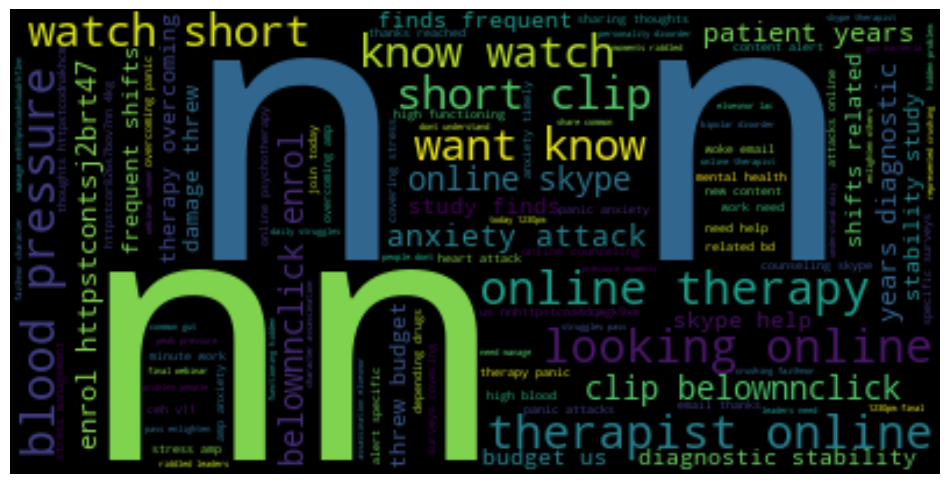

In [23]:
plot_wordcloud(anxiety_docx,'anxiety')

Emotion : depression

In [24]:
depression_list = df[df['label'] == 'depression']['clean_text'].tolist()
depression_docx = ' '.join(depression_list)

In [25]:
depression_keywords = extract_keywords(depression_docx)

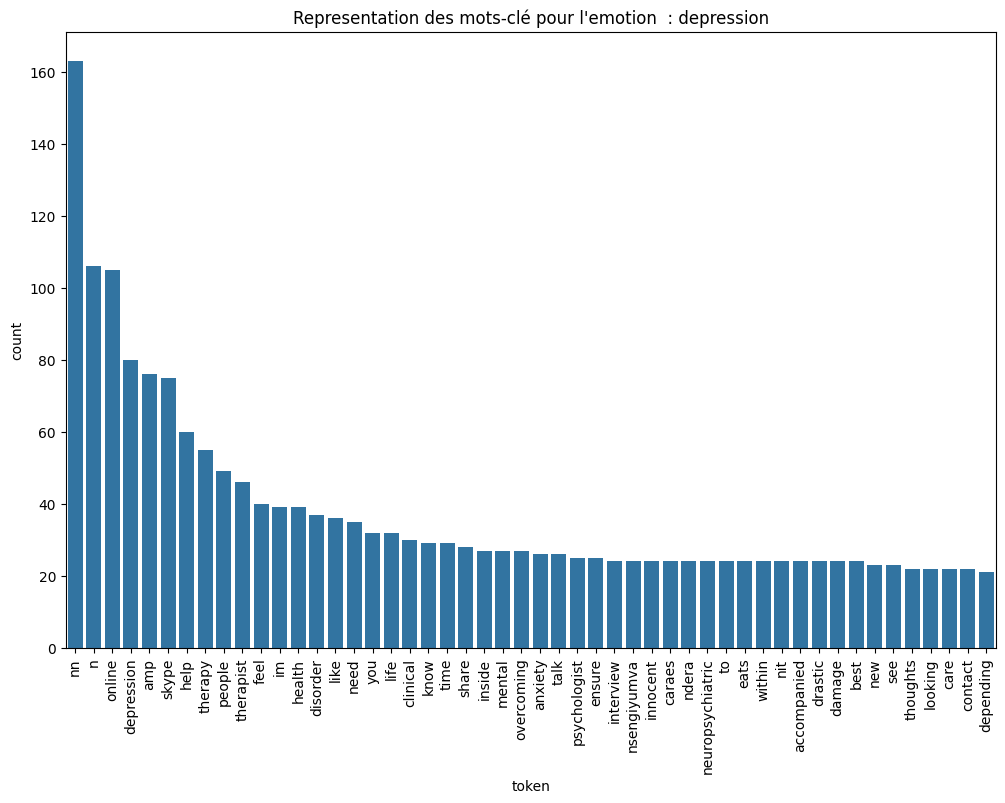

In [26]:
plot_most_common_wors(mydict=depression_keywords ,emotion_name='depression')

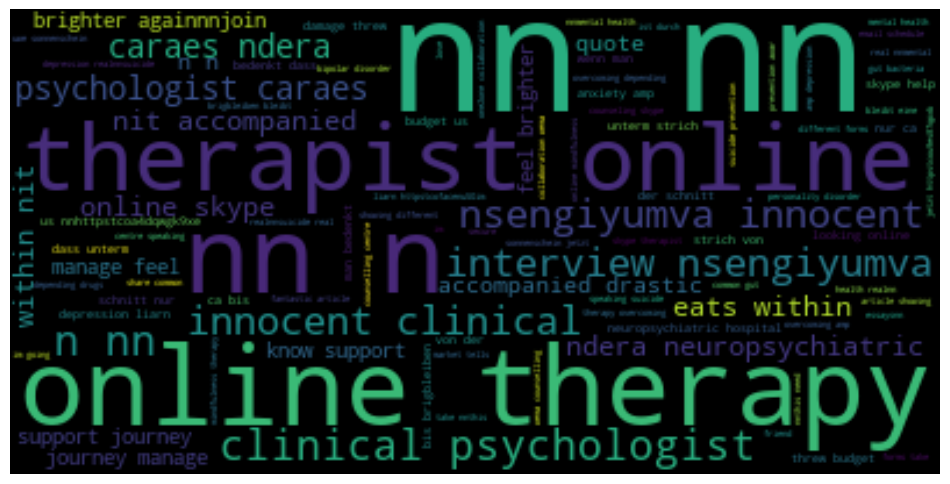

In [27]:
plot_wordcloud(depression_docx,'depression')

Emotion : happy

In [28]:
happy_list = df[df['label'] == 'happy']['clean_text'].tolist()
happy_docx = ' '.join(happy_list)

In [29]:
happy_keywords = extract_keywords(happy_docx)

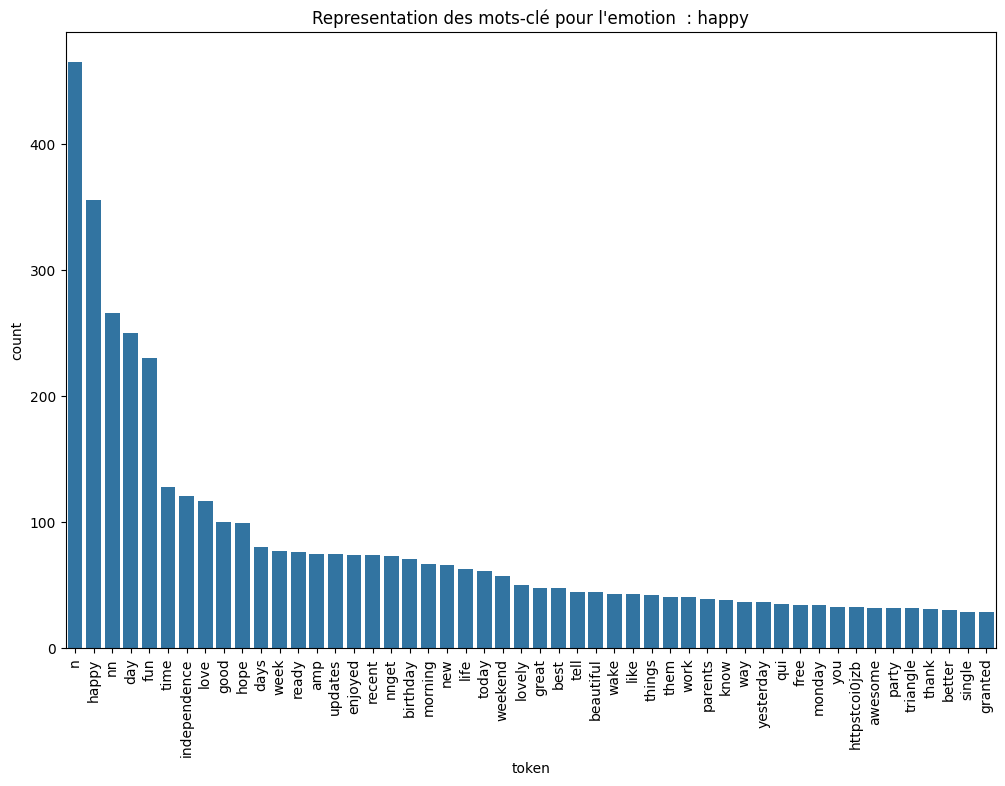

In [30]:
plot_most_common_wors(mydict=happy_keywords ,emotion_name='happy')

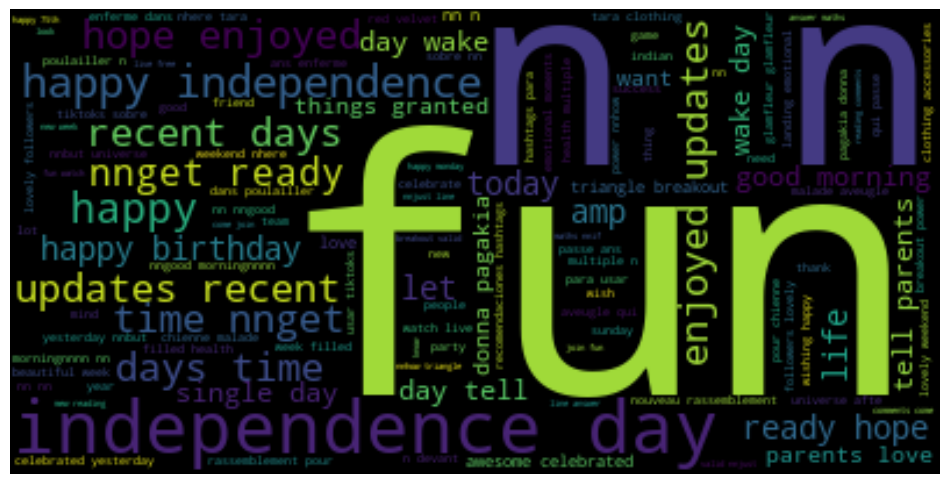

In [31]:
plot_wordcloud(happy_docx,'happy')

Emotion : stress

In [32]:
stress_list = df[df['label'] == 'stress']['clean_text'].tolist()
stress_docx = ' '.join(stress_list)

In [33]:
stress_keywords = extract_keywords(stress_docx)

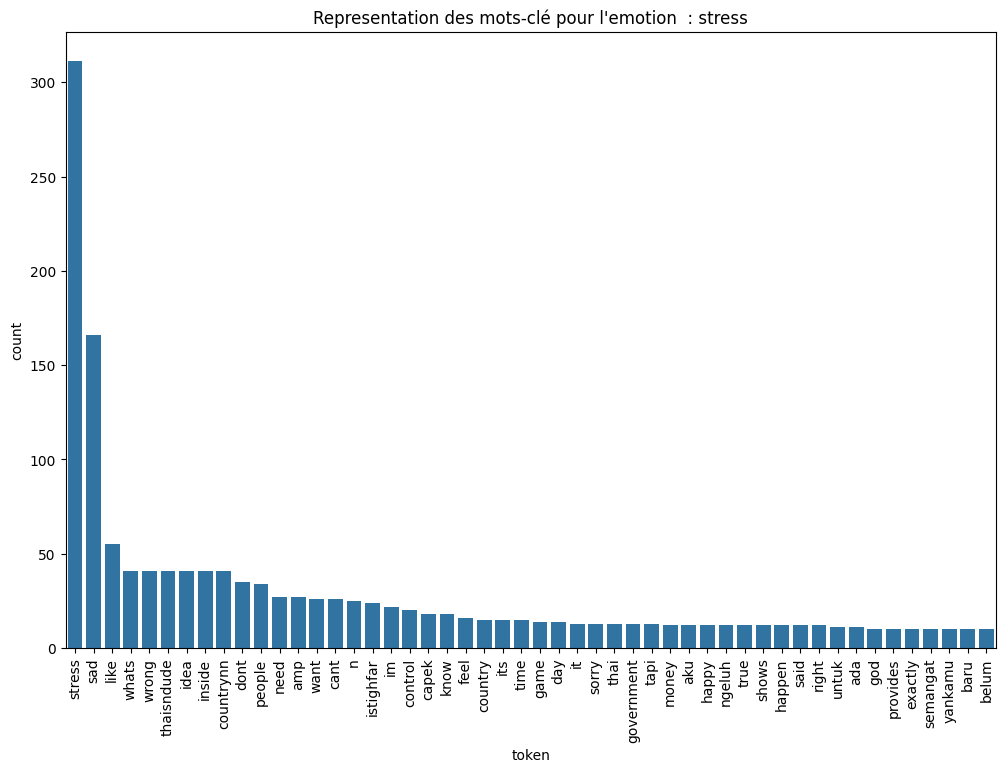

In [34]:
plot_most_common_wors(mydict=stress_keywords ,emotion_name='stress')

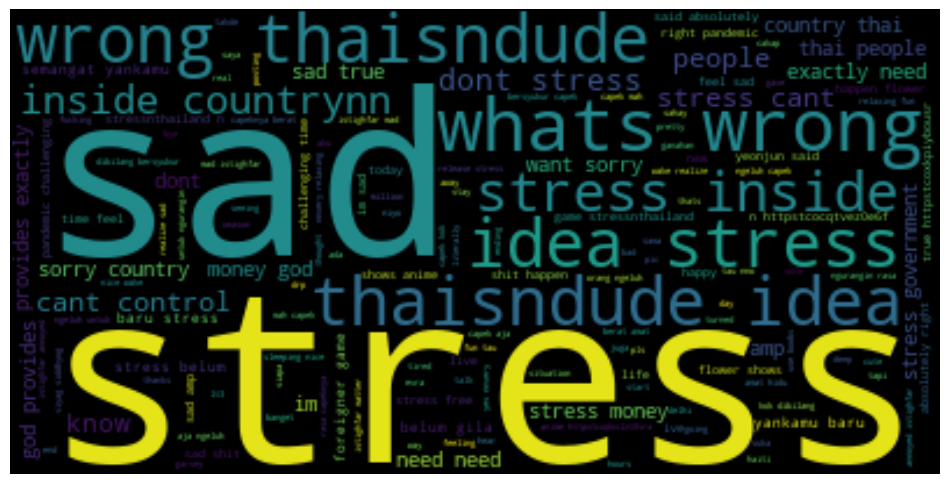

In [35]:
plot_wordcloud(stress_docx,'stress')

In [36]:
X = df['clean_text']
y = df['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)


In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4825,)
(4825,)
(1207,)
(1207,)


In [38]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', None)  # Placeholder for classifier
])

In [39]:
# Define the parameters grid for each classifier
parameters_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__max_iter': [200, 400],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    {
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'rbf']
    },
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 0.5, 1.0]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
]


In [40]:
# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)  

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Print the best model and its accuracy
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
print("Best Model:", best_model)
print("Best Accuracy:", best_accuracy)

In [ ]:
with open("../models/emotion_classifier.pkl","wb") as modelfile:
    joblib.dump(best_model,modelfile)

In [ ]:
pipe = joblib.load(open('../models/emotion_classifier.pkl','rb'))

In [ ]:
test_text = ['I am happy']

In [ ]:
pipe.predict(test_text)

In [ ]:
pipe.predict_proba(test_text)